In [20]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import random
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
from gym import spaces
import math

In [21]:
class RadarEnv(gym.Env):
    def __init__(self):
        super(RadarEnv, self).__init__()
        # 定义状态空间
        self.observation_space = spaces.Tuple((
            spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            spaces.Discrete(3),  # 雷达工作模式：0表示搜索，1表示跟踪，2表示制导
            spaces.Discrete(3),
            spaces.Discrete(3),
            
        ))
        self.n=10
        # 定义动作空间
        self.action_space = spaces.Tuple((
            spaces.Discrete(3),
            spaces.Discrete(4*self.n)
        ))
        
        self.state=[4.5*10**5,0,0,0]
        self.v=300
        self.ever_state=[0,0,0]
        self.ever_check_1=0
        self.ever_check_2=0
        self.ever_check_3=0
        self.count_1=0
        self.count_2=0
        self.count_3=0

    def reset(self):
        self.state=[450000,0,0,0]
        self.v=300
        self.ever_state=[0,0,0]
        self.ever_check_1=0
        self.ever_check_2=0
        self.ever_check_3=0
        self.count_1=0
        self.count_2=0
        self.count_3=0
        return self.state

    def step(self, action):
        done=False
        action_1=action//40
        action_2=action%40
        action=[action_1,action_2]
        if self.state[0]>400000:
            k=action[1]//10+9.5
        else:
            k=action[1]//10+17
        R_j_1=(self.state[0]**2+5000**2)**0.5
        R_j_2=self.state[0]
        R_j_3=(self.state[0]**2+5000**2)**0.5
        if action[0]==1:
            theta_j_1=math.atan(5000/self.state[0])
            theta_j_2=0
            theta_j_3=math.atan(5000/self.state[0])
            P_j_1=100
            P_j_2=100*(action[1]%10+1)
            P_j_3=100
            R_max_1=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_1**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_1/(R_j_1**2-1000**2)**0.5)+(P_j_1*10**1.5*10**4.2*math.cos(theta_j_1)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_1**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_1**4)/k/(1.38e-23*290*10*4e7+P_j_1*10**(-(20*math.log10(R_j_1)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            R_max_2=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_2**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_2/(R_j_2**2-1000**2)**0.5)+(P_j_2*10**1.5*10**4.2*math.cos(theta_j_2)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_2**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_2**4)/k/(1.38e-23*290*10*4e7+P_j_2*10**(-(20*math.log10(R_j_2)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            R_max_3=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_3**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_3/(R_j_3**2-1000**2)**0.5)+(P_j_3*10**1.5*10**4.2*math.cos(theta_j_3)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_3**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_3**4)/k/(1.38e-23*290*10*4e7+P_j_3*10**(-(20*math.log10(R_j_3)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            if R_j_1<=R_max_1:
                self.ever_check_1+=1
            if R_j_2<=R_max_2:
                self.ever_check_2+=1
            if R_j_3<=R_max_3:
                self.ever_check_3+=1
        elif action[0]==0:
            theta_j_1=math.atan(5000/self.state[0])
            theta_j_2=0
            theta_j_3=math.atan(5000/self.state[0])
            P_j_1=100*(action[1]%10+1)
            P_j_2=100
            P_j_3=100
            R_max_1=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_1**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_1/(R_j_1**2-1000**2)**0.5)+(P_j_1*10**1.5*10**4.2*math.cos(theta_j_1)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_1**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_1**4)/k/(1.38e-23*290*10*4e7+P_j_1*10**(-(20*math.log10(R_j_1)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            R_max_2=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_2**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_2/(R_j_2**2-1000**2)**0.5)+(P_j_2*10**1.5*10**4.2*math.cos(theta_j_2)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_2**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_2**4)/k/(1.38e-23*290*10*4e7+P_j_2*10**(-(20*math.log10(R_j_2)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            R_max_3=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_3**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_3/(R_j_3**2-1000**2)**0.5)+(P_j_3*10**1.5*10**4.2*math.cos(theta_j_3)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_3**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_3**4)/k/(1.38e-23*290*10*4e7+P_j_3*10**(-(20*math.log10(R_j_3)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            if R_j_1<=R_max_1:
                self.ever_check_1+=1
            if R_j_2<=R_max_2:
                self.ever_check_2+=1
            if R_j_3<=R_max_3:
                self.ever_check_3+=1
        elif action[0]==2:
            theta_j_1=math.atan(5000/self.state[0])
            theta_j_2=0
            theta_j_3=math.atan(5000/self.state[0])
            P_j_1=100
            P_j_2=100
            P_j_3=100*(action[1]%10+1)
            R_max_1=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_1**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_1/(R_j_1**2-1000**2)**0.5)+(P_j_1*10**1.5*10**4.2*math.cos(theta_j_1)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_1**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_1**4)/k/(1.38e-23*290*10*4e7+P_j_1*10**(-(20*math.log10(R_j_1)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            R_max_2=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_2**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_2/(R_j_2**2-1000**2)**0.5)+(P_j_2*10**1.5*10**4.2*math.cos(theta_j_2)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_2**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_2**4)/k/(1.38e-23*290*10*4e7+P_j_2*10**(-(20*math.log10(R_j_2)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            R_max_3=((77000*10**4.2*10**4.2*0.0375**2*6*256)/((4*math.pi)**3*(1.38e-23*290*10*4e7+((77000*10**4.2*10**4.2*0.0375**2)/((4*math.pi)**3*R_j_3**3*10**0.6)*10**-3.6*(3e8*(6.4e-6)/2)*(70/10**2.1*math.pi/180)*R_j_3/(R_j_3**2-1000**2)**0.5)+(P_j_3*10**1.5*10**4.2*math.cos(theta_j_3)**2*0.0375**2*10**0.05)/(4*math.pi)**2/R_j_3**2))/((77000*10**4.2*10**4.2*0.0375**2*6/(4*math.pi)**3/R_j_3**4)/k/(1.38e-23*290*10*4e7+P_j_3*10**(-(20*math.log10(R_j_3)+20*math.log10(400e6)+20*math.log10(4*math.pi/3e8))/10)))/10**0.6)**0.25
            if R_j_1<=R_max_1:
                self.ever_check_1+=1
            if R_j_2<=R_max_2:
                self.ever_check_2+=1
            if R_j_3<=R_max_3:
                self.ever_check_3+=1

        #print(R_max_1,R_max_2,R_max_3,k,action[1]%10+1)

        self.count_1+=1
        self.count_2+=1
        self.count_3+=1

        self.ever_state[0]=self.state[1]
        self.ever_state[1]=self.state[2]
        self.ever_state[2]=self.state[3]
        #第1个雷达状态转移
        if self.state[1]==0 and self.count_1==4 and self.ever_check_1>=3:
            self.state[1]=1
            self.count_1=0
            self.ever_check_1=0
        if self.state[1]==1 and self.count_1==3 and self.ever_check_1>=2:
            self.state[1]=2
            self.count_1=0
            self.ever_check_1=0
        if self.state[1]==1 and self.count_1==3 and self.ever_check_1==0:
            self.state[1]=0
            self.count_1=0
            self.ever_check_1=0
        #第2个雷达状态转移
        if self.state[2]==0 and self.count_2==4 and self.ever_check_2>=3:
            self.state[2]=1
            self.count_2=0
            self.ever_check_2=0
        if self.state[2]==1 and self.count_2==3 and self.ever_check_2>=2:
            self.state[2]=2
            self.count_2=0
            self.ever_check_2=0
        if self.state[2]==1 and self.count_2==3 and self.ever_check_2==0:
            self.state[2]=0
            self.count_2=0
            self.ever_check_2=0
        #第3个雷达状态转移
        if self.state[3]==0 and self.count_3==4 and self.ever_check_3>=3:
            self.state[3]=1
            self.count_3=0
            self.ever_check_3=0
        if self.state[3]==1 and self.count_3==3 and self.ever_check_3>=2:
            self.state[3]=2
            self.count_3=0
            self.ever_check_3=0
        if self.state[3]==1 and self.count_3==3 and self.ever_check_3==0:
            self.state[3]=0
            self.count_3=0
            self.ever_check_3=0
        
        self.state[0]-=self.v
        # 计算奖励
        reward = self._calculate_reward(action=action)
        # 检查是否达到终止条件
        done = self._check_termination()
        return self.state, reward, done, {}

    def _calculate_reward(self,action):
        #干扰成功奖励
        if self.state[1]+self.state[2]+self.state[3]==self.ever_state[0]+self.ever_state[1]+self.ever_state[2]:
            R1=1
        elif self.state[1]+self.state[2]+self.state[3]<self.ever_state[0]+self.ever_state[1]+self.ever_state[2]:
            R1=5
        else:
            R1=-5
        #干扰功率奖励
        if action[1]%10==0:
            R2=-0.5
        elif action[1]%10==1:
            R2=-0.4
        elif action[1]%10==2:
            R2=-0.3
        elif action[1]%10==3:
            R2=-0.2
        elif action[1]%10==4:
            R2=-0.1
        elif action[1]%10==5:
            R2=0.1
        elif action[1]%10==6:
            R2=0.2
        elif action[1]%10==7:
            R2=0.3
        elif action[1]%10==8:
            R2=0.4
        elif action[1]%10==9:
            R2=0.5
        #干扰样式奖励
        n_t=(450000-self.state[0])/self.v
        if self.state[0]>321000 and self.state[0]<=450000:
            if action[1]//10==0:
                R3=5-(5*self.v)/(450000-321000)*n_t
            else:
                R3=-0.5
        elif self.state[0]>139000 and self.state[0]<=321000:
            if action[1]//10==1:
                R3=5-(5*self.v)/(321000-139000)*n_t
            else:
                R3=-0.5
        elif self.state[0]>77000 and self.state[0]<=139000:
            if action[1]//10==2:
                R3=5-(5*self.v)/(1390000-77000)*n_t
            else:
                R3=-0.5
        elif self.state[0]>16000 and self.state[0]<=77000:
            if action[1]//10==3:
                R3=5-(5*self.v)/(77000-16000)*n_t-1.5
            else:
                R3=-0.5
        else:
            if action[1]//10==3:
                R3=0.5
            else:
                R3=-0.5
        #奖励总值
        reward=R1+R2+R3
        return reward

    def _check_termination(self):
        if self.state[0]<=1000 or self.state[1]==2 or self.state[2]==2 or self.state[3]==2:
            return True
        else:
            return False

In [22]:
class ReplayBuffer:
    ''' 经验回放池 '''

    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [23]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [24]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
        max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [25]:
lr = 0.001
num_episodes = 1200
gamma = 0.9
epsilon = 0.1
target_update = 320
buffer_size = 2000
minimal_size = 500
batch_size = 120
device = torch.device("cuda")
random.seed(0)
np.random.seed(0)
env =RadarEnv()
env.reset()
replay_buffer = ReplayBuffer(buffer_size)
state_dim = 4
action_dim = 120
hidden_dim = 128
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

action_P_sum_list=[]
distance_list=[450000]
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action_P=[]
            done = False
            while not done:
                action = agent.take_action(state)
                action_P.append(action%40)
                #print(action)
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                #print(state)
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            action_P_sum_list.append(sum(action_P)/(len(action_P)*40))
            distance_list.append(state[0]/1000)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 120/120 [00:47<00:00,  2.52it/s, episode=1200, return=997.673]


In [26]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

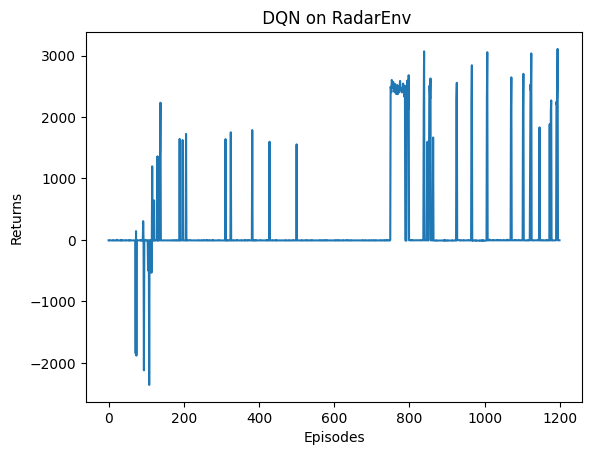

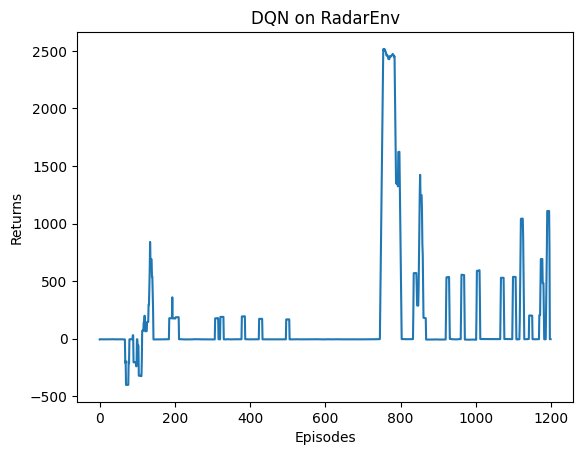

In [27]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(' DQN on {}'.format("RadarEnv"))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format("RadarEnv"))
plt.show()

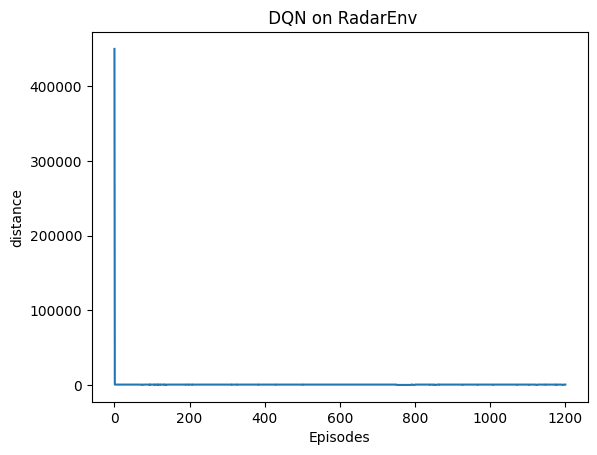

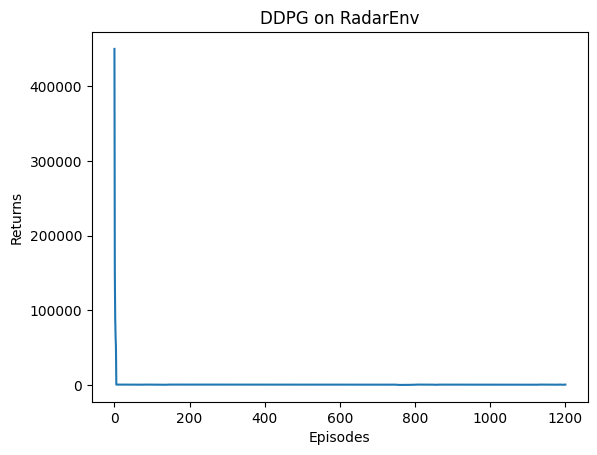

In [28]:
episodes_list = list(range(len(distance_list)))
plt.plot(episodes_list, distance_list)
plt.xlabel('Episodes')
plt.ylabel('distance')
plt.title(' DQN on {}'.format("RadarEnv"))
plt.show()

list_return = moving_average(distance_list, 9)
plt.plot(episodes_list, list_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format("RadarEnv"))
plt.show()

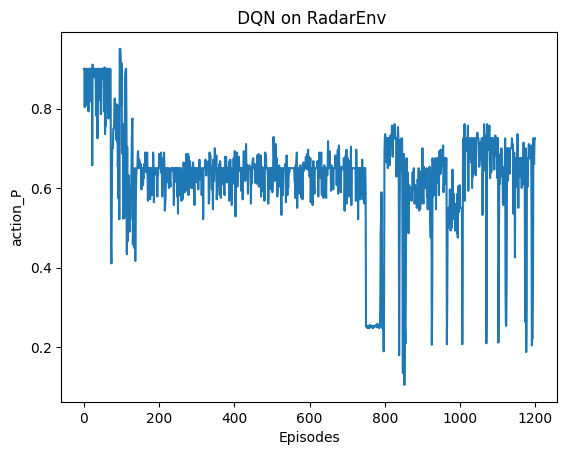

In [29]:
episodes_list = list(range(len(action_P_sum_list)))
plt.plot(episodes_list, action_P_sum_list)
plt.xlabel('Episodes')
plt.ylabel('action_P')
plt.title(' DQN on {}'.format("RadarEnv"))
plt.show()